<a href="https://colab.research.google.com/github/hatw15/Taewon/blob/main/Arc2Face%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Arc2Face 클론 & 디렉토리 이동
!git clone https://github.com/foivospar/Arc2Face.git
%cd Arc2Face

Cloning into 'Arc2Face'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 141 (delta 34), reused 16 (delta 15), pack-reused 98 (from 1)
Receiving objects: 100% (141/141), 29.08 MiB | 15.87 MiB/s, done.
Resolving deltas: 100% (63/63), done.
/content/Arc2Face


In [3]:
# 1) numpy (1.23.x)
%pip install "numpy<1.24.0"

# 2) torch + torchvision (GPU 빌드)
%pip install torch==2.0.1 torchvision==0.15.2 \
    -f https://download.pytorch.org/whl/cu118/torch_stable.html

# 3) Arc2Face 요구사항
%pip install diffusers==0.23.0 \
            transformers==4.34.1 \
            peft \
            accelerate \
            insightface \
            onnxruntime-gpu \
            gradio

Looking in links: https://download.pytorch.org/whl/cu118/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 372.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.21.0+cu124
    Uninstalling torchvision-0.21.0+cu124:
      Successfully uninstalled torchvision-0.21.0+cu124
ERROR: pip's dependency resolver does not currently take into account all the packages that are ins

In [1]:
from huggingface_hub import hf_hub_download

hf_hub_download(repo_id="FoivosPar/Arc2Face", filename="arc2face/config.json", local_dir="./models")
hf_hub_download(repo_id="FoivosPar/Arc2Face", filename="arc2face/diffusion_pytorch_model.safetensors", local_dir="./models")
hf_hub_download(repo_id="FoivosPar/Arc2Face", filename="encoder/config.json", local_dir="./models")
hf_hub_download(repo_id="FoivosPar/Arc2Face", filename="encoder/pytorch_model.bin", local_dir="./models")

'./models/encoder/pytorch_model.bin'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Colab에서 실행
!mkdir -p models/antelopev2
!unzip "/content/drive/MyDrive/antelopev2.zip" -d models/antelopev2

Archive:  /content/drive/MyDrive/antelopev2.zip
   creating: models/antelopev2/antelopev2/
  inflating: models/antelopev2/antelopev2/genderage.onnx  
  inflating: models/antelopev2/antelopev2/2d106det.onnx  
  inflating: models/antelopev2/antelopev2/1k3d68.onnx  
  inflating: models/antelopev2/antelopev2/glintr100.onnx  
  inflating: models/antelopev2/antelopev2/scrfd_10g_bnkps.onnx  


In [4]:
hf_hub_download(repo_id="FoivosPar/Arc2Face", filename="arcface.onnx", local_dir="./models/antelopev2")

arcface.onnx:   0%|          | 0.00/261M [00:00<?, ?B/s]

'models/antelopev2/arcface.onnx'

In [3]:
%pip uninstall -y peft
%pip install peft==0.5.0

Found existing installation: peft 0.13.2
Uninstalling peft-0.13.2:
  Successfully uninstalled peft-0.13.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 6.8 MB/s eta 0:00:00


In [5]:
# 1) Huggingface Hub 버전 고정 (cached_download + split_* 모두 포함)
%pip install huggingface_hub==0.17.3

# 2) Accelerate 버전도 호환되는 버전으로 고정
%pip install accelerate==0.20.3


  Using cached accelerate-0.20.3-py3-none-any.whl.metadata (17 kB)
Using cached accelerate-0.20.3-py3-none-any.whl (227 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.32.1
    Uninstalling accelerate-0.32.1:
      Successfully uninstalled accelerate-0.32.1


In [2]:
import sys, os
# Arc2Face 클론 경로에 맞게 변경
sys.path.append(os.path.abspath("/content/Arc2Face"))

from diffusers import (
    StableDiffusionPipeline,
    UNet2DConditionModel,
    DPMSolverMultistepScheduler,
)

from arc2face import CLIPTextModelWrapper, project_face_embs

import torch
from insightface.app import FaceAnalysis
from PIL import Image
import numpy as np

# Arc2Face is built upon SD1.5
# The repo below can be used instead of the now deprecated 'runwayml/stable-diffusion-v1-5'
base_model = 'stable-diffusion-v1-5/stable-diffusion-v1-5'

encoder = CLIPTextModelWrapper.from_pretrained(
    'models', subfolder="encoder", torch_dtype=torch.float16
)

unet = UNet2DConditionModel.from_pretrained(
    'models', subfolder="arc2face", torch_dtype=torch.float16
)

pipeline = StableDiffusionPipeline.from_pretrained(
        base_model,
        text_encoder=encoder,
        unet=unet,
        torch_dtype=torch.float16,
        safety_checker=None
    )

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [3]:
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline = pipeline.to('cuda')

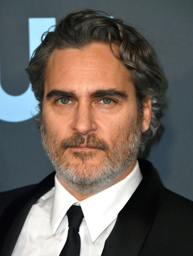

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


In [4]:
from PIL import Image
from IPython.display import display
# 원본 이미지 표시
orig = Image.open('/content/Arc2Face/assets/examples/joacquin.png')

# 최대 가로·세로를 256px로 줄이되 비율 유지
orig_small = orig.copy()
orig_small.thumbnail((256, 256))

# 축소된 이미지 표시
display(orig_small)

app = FaceAnalysis(providers=["CUDAExecutionProvider","CPUExecutionProvider"])
app.prepare(ctx_id=0, det_size=(640,640))

img = np.array(Image.open('/content/Arc2Face/assets/examples/joacquin.png'))[:,:,::-1]

faces = app.get(img)
faces = sorted(faces, key=lambda x:(x['bbox'][2]-x['bbox'][0])*(x['bbox'][3]-x['bbox'][1]))[-1]  # select largest face (if more than one detected)
id_emb = torch.tensor(faces['embedding'], dtype=torch.float16)[None].cuda()
id_emb = id_emb/torch.norm(id_emb, dim=1, keepdim=True)   # normalize embedding
id_emb = project_face_embs(pipeline, id_emb)    # pass through the encoder

In [5]:
num_images = 4
images = pipeline(prompt_embeds=id_emb, num_inference_steps=25, guidance_scale=3.0, num_images_per_prompt=num_images).images

  0%|          | 0/25 [00:00<?, ?it/s]

In [15]:
# 셸에서 실행 → PEFT 제거
%pip uninstall -y peft


Found existing installation: peft 0.4.0
Uninstalling peft-0.4.0:
  Successfully uninstalled peft-0.4.0


In [15]:
# zero_emb 생성 (1×512 크기의 제로 벡터)
zero_emb = torch.zeros((1, 512), dtype=torch.float16, device="cuda")
# project_face_embs 로 negative prompt embedding 생성
neg_emb  = project_face_embs(pipeline, zero_emb)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/15 [00:00<?, ?it/s]

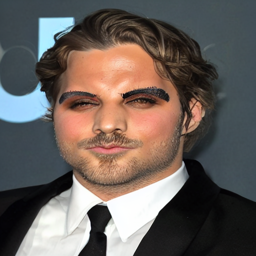

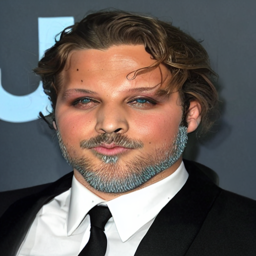

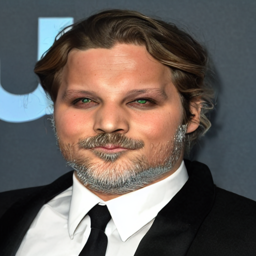

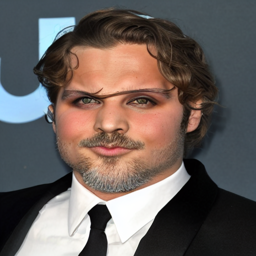

In [18]:
# 1) Img2Img 파이프라인 준비 (이미 만드셨던 부분)
from diffusers import StableDiffusionImg2ImgPipeline
from torch import Generator
from IPython.display import display

img2img = StableDiffusionImg2ImgPipeline.from_pretrained(
    base_model,
    text_encoder=encoder,
    unet=unet,
    scheduler=pipeline.scheduler,
    torch_dtype=torch.float16
).to("cuda")

# 2) 호출 시 image=init 으로 넘겨야 init 이미지가 제대로 들어감
from torch import Generator
gen = Generator("cuda").manual_seed(1234)
init = orig.resize((512,512))

outputs = img2img(
    image                   = init,       # ★ 여기 ★
    prompt_embeds           = id_emb,
    negative_prompt_embeds  = neg_emb,
    strength                = 0.3,
    num_inference_steps     = 50,
    guidance_scale          = 7.5,
    num_images_per_prompt   = 4,
    generator               = gen
)

# 3) 결과 표시
for img in outputs.images:
    img.thumbnail((256,256))
    display(img)
